## Neg-Inhib HDDm Analysis

In this analysis, we fit a version of the diffusion model that takes participant-level variability into account. As Wiecki et al. (2013) put it, 

> Hierarchical Bayesian methods provide a remedy for this problem by allowing group and subject parameters to be estimated simultaneously at different hierarchical levels ([LeeWagenmakers13], [Kruschke10], [VandekerckhoveTuerlinckxLee11]). Subject parameters are assumed to be drawn from a group distribution, and to the degree that subject are similar to each other, the variance in the group distribution will be estimated to be small, which reciprocally has a greater influence on constraining parameter estimates of any individual. Even in this scenario, the method still allows the posterior for any given individual subject to differ substantially from that of the rest of the group given sufficient data to overwhelm the group prior. Thus the method capitalizes on statistical strength shared across the individuals, and can do so to different degrees even within the same sample and model, depending on the extent to which subjects are similar to each other in one parameter vs. another.

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import hddm
import os
import hddm_helpers

In [2]:
data = hddm.load_csv("../../data/raw_data/neginhib_adult_hddm.csv")
data.head()

,X1,subid,list,game.order,trial.num,word,leftpic,rightpic,game,trial.type,leftpic.type,rightpic.type,side.chosen,pic.chosen,response,date,timestamp,rt,response_numeric
0,1,1,2,4,1,cat_control,cat_control,cat_foil,implicature,unambiguous,target,distractor,L,cat_control,Y,7/23/2015,12:17:00,1.315,1
1,2,1,2,4,2,bicycle_control,bicycle_foil,bicycle_control,implicature,unambiguous,distractor,target,R,bicycle_control,Y,7/23/2015,12:17:00,1.429,1
2,3,1,2,4,3,cup_control,cup_foil,cup_control,implicature,unambiguous,distractor,target,R,cup_control,Y,7/23/2015,12:17:00,0.915,1
3,4,1,2,4,4,teddybear_control,teddybear_foil,teddybear_control,implicature,unambiguous,distractor,target,R,teddybear_control,Y,7/23/2015,12:17:00,0.964,1
4,5,1,2,4,5,bird_control,bird_foil,bird_control,implicature,unambiguous,distractor,target,R,bird_control,Y,7/23/2015,12:17:00,0.724,1


In [3]:
# process data for fitting hddm
data = data.dropna(subset = ['rt'])
data = data.rename(columns = {'trial.type':'trial_type'})
data['subj_idx'] = data.subid
data['response'] = data.response_numeric
data = hddm.utils.flip_errors(data)
data = data.dropna()
data.head()

,X1,subid,list,game.order,trial.num,word,leftpic,rightpic,game,trial_type,leftpic.type,rightpic.type,side.chosen,pic.chosen,response,date,timestamp,rt,response_numeric,subj_idx
0,1,1,2,4,1,cat_control,cat_control,cat_foil,implicature,unambiguous,target,distractor,L,cat_control,1,7/23/2015,12:17:00,1.315,1,1
1,2,1,2,4,2,bicycle_control,bicycle_foil,bicycle_control,implicature,unambiguous,distractor,target,R,bicycle_control,1,7/23/2015,12:17:00,1.429,1,1
2,3,1,2,4,3,cup_control,cup_foil,cup_control,implicature,unambiguous,distractor,target,R,cup_control,1,7/23/2015,12:17:00,0.915,1,1
3,4,1,2,4,4,teddybear_control,teddybear_foil,teddybear_control,implicature,unambiguous,distractor,target,R,teddybear_control,1,7/23/2015,12:17:00,0.964,1,1
4,5,1,2,4,5,bird_control,bird_foil,bird_control,implicature,unambiguous,distractor,target,R,bird_control,1,7/23/2015,12:17:00,0.724,1,1


In [4]:
# check to make sure we have data for each game from each participant
subids = data.subid.unique()
for id in subids:
    print(id, data[data.subid == id].game.unique())

1 ['implicature' 'inhibition' 'negation']
2 ['negation' 'inhibition' 'implicature']
3 ['negation' 'inhibition' 'implicature']
4 ['implicature' 'negation' 'inhibition']
5 ['negation' 'inhibition' 'implicature']
6 ['negation' 'inhibition' 'implicature']
7 ['implicature' 'inhibition' 'negation']
8 ['implicature' 'inhibition' 'negation']
9 ['implicature' 'negation' 'inhibition']
10 ['implicature' 'inhibition' 'negation']
11 ['implicature' 'negation' 'inhibition']
12 ['negation' 'implicature' 'inhibition']
13 ['implicature' 'negation' 'inhibition']
14 ['negation' 'implicature' 'inhibition']
15 ['inhibition' 'negation' 'implicature']
16 ['inhibition' 'negation' 'implicature']
17 ['implicature' 'negation' 'inhibition']
18 ['negation' 'implicature' 'inhibition']
19 ['negation' 'inhibition' 'implicature']
20 ['negation' 'implicature' 'inhibition']
21 ['inhibition' 'negation' 'implicature']
22 ['implicature' 'negation' 'inhibition']
23 ['negation' 'implicature' 'inhibition']
24 ['negation' 'impl

In [17]:
# drop participant number 50 because we only have one game's worth of data
data = data[data.subid != 50]
data.tail()

,X1,subid,list,game.order,trial.num,word,leftpic,rightpic,game,trial_type,leftpic.type,rightpic.type,side.chosen,pic.chosen,response,date,timestamp,rt,response_numeric,subj_idx
19749,19786,49,1,2,116,dog_pos,dog_pos,dog_neg,negation,positive,target,distractor,L,dog_pos,1,7/24/2015,11:21:00,0.806,1,49
19750,19787,49,1,2,117,car_neg,car_neg,car_pos,negation,negative,target,distractor,L,car_neg,1,7/24/2015,11:21:00,0.693,1,49
19751,19788,49,1,2,118,flower_pos,flower_neg,flower_pos,negation,positive,distractor,target,R,flower_pos,1,7/24/2015,11:21:00,0.878,1,49
19752,19789,49,1,2,119,teddybear_pos,teddybear_pos,teddybear_neg,negation,positive,target,distractor,L,teddybear_pos,1,7/24/2015,11:21:00,0.944,1,49
19753,19790,49,1,2,120,bird_pos,bird_pos,bird_neg,negation,positive,target,distractor,L,bird_pos,1,7/24/2015,11:21:00,0.742,1,49


game         trial_type   response
implicature  implicature  0           AxesSubplot(0.125,0.125;0.775x0.755)
                          1           AxesSubplot(0.125,0.125;0.775x0.755)
             unambiguous  0           AxesSubplot(0.125,0.125;0.775x0.755)
                          1           AxesSubplot(0.125,0.125;0.775x0.755)
inhibition   control      0           AxesSubplot(0.125,0.125;0.775x0.755)
                          1           AxesSubplot(0.125,0.125;0.775x0.755)
             inhib        0           AxesSubplot(0.125,0.125;0.775x0.755)
                          1           AxesSubplot(0.125,0.125;0.775x0.755)
negation     negative     0           AxesSubplot(0.125,0.125;0.775x0.755)
                          1           AxesSubplot(0.125,0.125;0.775x0.755)
             positive     0           AxesSubplot(0.125,0.125;0.775x0.755)
                          1           AxesSubplot(0.125,0.125;0.775x0.755)
Name: rt, dtype: object

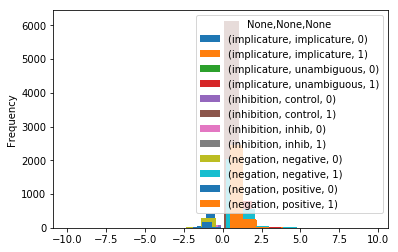

In [18]:
data.groupby(['game', 'trial_type', 'response'])['rt'].plot.hist(legend=True)

# Fit HDDM with variable drift, boundary, non-decision time, and bias

Here we fit the ddm for each participant, but now we allow the drift rate,  boundary separation, and non-decision time to vary across the six different trial types. 

We also fit a model including within-subject effects of `trial_type` since these are nested within participants. We do this by estimating an intercept to capture overall performance in the `control` trials in the inhibition game as a baseline, and then estimate all the other conditions (trial types) relative to this baseline.

In [7]:
# we can check out the design matrix of the model here
from patsy import dmatrix

#dmatrix("C(game, Treatment(reference='inhibition') + C(trial_type, Treatment(reference='control'))", data)
dmatrix("C(trial_type, Treatment(reference='positive'))", data)

DesignMatrix with shape (19754, 6)
  Columns:
    ['Intercept',
     "C(trial_type, Treatment(reference='positive'))[T.control]",
     "C(trial_type, Treatment(reference='positive'))[T.implicature]",
     "C(trial_type, Treatment(reference='positive'))[T.inhib]",
     "C(trial_type, Treatment(reference='positive'))[T.negative]",
     "C(trial_type, Treatment(reference='positive'))[T.unambiguous]"]
  Terms:
    'Intercept' (column 0)
    "C(trial_type, Treatment(reference='positive'))" (columns 1:6)
  (to view full data, use np.asarray(this_obj))

In [9]:
n_samples = 5000
n_burn = 500

m1 = hddm.HDDMRegressor(data, 
                        ["v ~ C(trial_type, Treatment(reference='positive'))",
                         "a ~ C(trial_type, Treatment(reference='positive'))",
                         "t ~ C(trial_type, Treatment(reference='positive'))",
                         "z ~ C(trial_type, Treatment(reference='positive'))"],
                       include='z')
m1.find_starting_values()
m1.sample(n_samples, burn = n_burn, dbname='trial_type_model.db', db='pickle')

Adding these covariates:
['v_Intercept', "v_C(trial_type, Treatment(reference='positive'))[T.control]", "v_C(trial_type, Treatment(reference='positive'))[T.implicature]", "v_C(trial_type, Treatment(reference='positive'))[T.inhib]", "v_C(trial_type, Treatment(reference='positive'))[T.negative]", "v_C(trial_type, Treatment(reference='positive'))[T.unambiguous]"]
Adding these covariates:
['a_Intercept', "a_C(trial_type, Treatment(reference='positive'))[T.control]", "a_C(trial_type, Treatment(reference='positive'))[T.implicature]", "a_C(trial_type, Treatment(reference='positive'))[T.inhib]", "a_C(trial_type, Treatment(reference='positive'))[T.negative]", "a_C(trial_type, Treatment(reference='positive'))[T.unambiguous]"]
Adding these covariates:
['t_Intercept', "t_C(trial_type, Treatment(reference='positive'))[T.control]", "t_C(trial_type, Treatment(reference='positive'))[T.implicature]", "t_C(trial_type, Treatment(reference='positive'))[T.inhib]", "t_C(trial_type, Treatment(reference='posi

/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1932: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 5001 of 5000 complete in 104529.9 sec

/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


# Fit HDDM with variable drift, boundary, and bias

In this model we pin non-decision time to be the same across the different trial types. We also add the chance for outliers so the model does not have to account for very fast RTs. 

From the HDDM docs, 

> The model predicts far more RTs near the leading edge of the distribution than are actually observed. This is because non-decision time t is forced to be estimated small enough to account for a few fast RTs. What we can do instead is fit a mixture model which assumes that outliers come from a uniform distribution. (Note, outliers do not have to be very fast or very slow, and the above example is just an obvious illustration. Some proportion of the trials can be assumed to simply come from a different process for which we make no assumptions about its generation, and hence use a uniform distribution. This allows the model to find the best DDM parameters that capture the majority of trials). Here, we specify that we expect roughly 5% outliers in our data.

In [8]:
n_samples = 5000
n_burn = 500

m2 = hddm.HDDMRegressor(data, 
                        ["v ~ C(trial_type, Treatment(reference='positive'))",
                         "a ~ C(trial_type, Treatment(reference='positive'))",
                         #"t ~ C(trial_type, Treatment(reference='positive'))",
                         "z ~ C(trial_type, Treatment(reference='positive'))"],
                        p_outlier=.05,
                        bias=True)
m2.find_starting_values()
m2.sample(n_samples, burn = n_burn)

Adding these covariates:
['v_Intercept', "v_C(trial_type, Treatment(reference='positive'))[T.control]", "v_C(trial_type, Treatment(reference='positive'))[T.implicature]", "v_C(trial_type, Treatment(reference='positive'))[T.inhib]", "v_C(trial_type, Treatment(reference='positive'))[T.negative]", "v_C(trial_type, Treatment(reference='positive'))[T.unambiguous]"]
Adding these covariates:
['a_Intercept', "a_C(trial_type, Treatment(reference='positive'))[T.control]", "a_C(trial_type, Treatment(reference='positive'))[T.implicature]", "a_C(trial_type, Treatment(reference='positive'))[T.inhib]", "a_C(trial_type, Treatment(reference='positive'))[T.negative]", "a_C(trial_type, Treatment(reference='positive'))[T.unambiguous]"]
Adding these covariates:
['z_Intercept', "z_C(trial_type, Treatment(reference='positive'))[T.control]", "z_C(trial_type, Treatment(reference='positive'))[T.implicature]", "z_C(trial_type, Treatment(reference='positive'))[T.inhib]", "z_C(trial_type, Treatment(reference='posi

/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1932: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 5001 of 5000 complete in 71971.0 sec

/Users/kmacdonald/miniconda3/envs/hddm_fit/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [32]:
m2.knodes

[t,
 t_std,
 t_rate,
 t_shape,
 t_subj,
 v_Intercept,
 v_Intercept_std,
 v_Intercept_tau,
 v_Intercept_subj,
 v_C(trial_type, Treatment(reference='positive'))[T.control],
 v_C(trial_type, Treatment(reference='positive'))[T.implicature],
 v_C(trial_type, Treatment(reference='positive'))[T.inhib],
 v_C(trial_type, Treatment(reference='positive'))[T.negative],
 v_C(trial_type, Treatment(reference='positive'))[T.unambiguous],
 v_reg,
 a_Intercept,
 a_Intercept_std,
 a_Intercept_rate,
 a_Intercept_shape,
 a_Intercept_subj,
 a_C(trial_type, Treatment(reference='positive'))[T.control],
 a_C(trial_type, Treatment(reference='positive'))[T.implicature],
 a_C(trial_type, Treatment(reference='positive'))[T.inhib],
 a_C(trial_type, Treatment(reference='positive'))[T.negative],
 a_C(trial_type, Treatment(reference='positive'))[T.unambiguous],
 a_reg,
 z_Intercept_trans,
 z_Intercept,
 z_Intercept_std,
 z_Intercept_tau,
 z_Intercept_subj_trans,
 z_Intercept_subj,
 z_C(trial_type, Treatment(reference=

## Extract and save chains for each parameter


In [9]:
m2.get_traces().to_csv("../../data/model_traces/neginhib-adult-mcmc-pinned-ndt.csv")
m2.get_group_traces().to_csv("../../data/model_traces/neginhib-adult-mcmc-group-pinned-ndt.csv")

## Fit between-subjects HDDM  (deprecated)

Next, we fit a between-subjects HDDM to compare against the within-subjects model's parameter estimates. 

**(note we decided this was not an appropiate model given the nested data, so we are not pursuing it further)**

In [ ]:
n_samples = 5000
n_burn = 200

m_between = hddm.HDDM(data, depends_on={'v': 'trial_type', 'a': 'trial_type', 't': 'trial_type'})
m_between.find_starting_values()
m_between.sample(n_samples, burn = n_burn)

Save results

In [ ]:
m_between.get_traces().to_csv("../../data/model_traces/neginhib-adult-mcmc-between-ss.csv")
m_between.get_group_traces().to_csv("../../data/model_traces/neginhib-adult-mcmc-group-between.csv")

## Test model convergence (TODO)

The Gelman-Rubin statistic provides a more formal test for convergence that compares the intra-chain variance to the intra-chain variance of different runs of the same model.

In [ ]:
models = []
for i in range(5):
    m = hddm.HDDM(data_inhib) 
    m.find_starting_values() 
    m.sample(5000, burn=20) 
    models.append(m)

hddm.analyze.gelman_rubin(models)